In [9]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
import statsmodels.api as sm
# from fuzzywuzzy import fuzz
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import random
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, balanced_accuracy_score, matthews_corrcoef
from scipy.stats import chi2_contingency

pip install fuzzywuzzy python-Levenshtein

# cleaning the datasets to prepare for merging

In [16]:
import math
def barplot(df, group_cols):
  
    n_cols = len(group_cols)
    n_rows = math.ceil(n_cols / 5)
    fig_width = 15
    fig_height = 15

    # Create subplot grid
    fig, axs = plt.subplots(n_rows, 5, figsize=(fig_width, fig_height))
    axs = axs.flatten()

    for i, col in enumerate(group_cols):
        proportions_df = df.groupby([col, 'General Status']).size().unstack(fill_value=0)
        proportions_df = proportions_df.div(proportions_df.sum(axis=1), axis=0)

        # Plot in subplot
        ax = axs[i]  # Select subplot
        proportions_df.plot(kind='bar', stacked=True, color=['lightblue', 'orange'], ax=ax, use_index=False,sharex=True,sharey=True)
        ax.set_title(f'{col}', fontsize=10,wrap=True)
        ax.legend(title='Won Primary', loc='upper right', labels=['No', 'Yes'],fontsize=5)

    # Hide unused subplots if any
    for j in range(i+1, len(axs)):
        fig.delaxes(axs[j])

    # Adjust layout and save
    plt.tight_layout()
    plt.savefig(f"grid_race_win.png")
    plt.legend(title='Won Primary', loc='upper right', labels=['No', 'Yes'],fontsize=5)
    plt.show()

In [11]:
def binarize_cols(df, nan_threshold=20):
    few_NaNs_cols = []
    for col in df.columns:
        if (df[col].nunique(dropna=False) == 2) or (df[col].nunique(dropna=True) == 2):
            unique_vals = df[col].unique()
            if (unique_vals[0] !=0 and unique_vals[1] !=0):
                print(f"col:{col}\n0 means:{unique_vals[0]}\n1 means: {unique_vals[1]}\n")
                df[col] = df[col].replace({unique_vals[0]: int(0), unique_vals[1]: int(1)})
            df[col].fillna(0, inplace=True) #now this will only make sense tho if we OHE first.    
    return df

def drop_columns(df, col_lst):
    for i in col_lst:
        if i in df.columns:
            df = df.drop(i, axis=1)
    return df


def move_column_to_front(df, col_lst):
    for column_name in col_lst:
        if column_name in df.columns:
            df = df[[column_name] + [col for col in df.columns if col != column_name]]
    return df

def get_info(df):
    print(f"COL VALUE TYPES \n{df.dtypes} \n\ndf shape:{df.shape}\n\nall the columns:\n{df.columns}")

def get_ohe_cols(df, unique_limit=16, exclude = ['total_runners_house','total_runners']):
    #object_cols = df.select_dtypes(include=['object']).columns
    res = [col for col in df.columns if ((df[col].nunique(dropna=False) <= unique_limit) and (df[col].nunique(dropna=False)>=2) and (col != 'total_runners') and (col != 'General Status') and (col !='Total Endorsements'))]
    return res

def zero_dropper(df):
    for col in df.columns:
        if ((df[col].astype(int)==1).mean() >= 0.80):
            df = df.drop(col, axis=1)
    return df

def drop_VIF_col(X, threshold=2):
    while True:
        vif_info = pd.DataFrame()
        vif_info['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        vif_info['Column'] = X.columns
        vif_info = vif_info.sort_values('VIF', ascending=False)
        max_VIF = vif_info['VIF'].iloc[0]

        if max_VIF > threshold:
            to_drop = vif_info['Column'].iloc[0]
            print(f"Dropped: {to_drop} with VIF of {max_VIF}")
            X = X.drop(to_drop, axis=1)
        else:
            break

    return X  # Returning the modified DataFrame

def convert_to_int_if_possible(df, col_lst):
    for column_name in col_lst:
        temp_col = pd.to_numeric(df[column_name], errors='coerce')
        if temp_col.isna().sum() == 0:
            if all(temp_col.dropna() == temp_col.dropna().astype(int)):
                df[column_name] = temp_col.astype(int)
    return df

def aic(X, y):
    best_features = []
    best_aic = float('inf')

    for feature in X.columns:
        # Create a temporary DataFrame with the current set of best features plus the new feature
        X_temp = sm.add_constant(X[best_features + [feature]])

       
        model = sm.Logit(y, X_temp)  # Fit the logistic regression model
        result = model.fit()  # disp=0 suppresses the fit output

        # Check AIC and update if it is lower
        if result.aic < best_aic:
            best_aic = result.aic
            best_features.append(feature)

    # Fit the final model with the best features
    X_final = sm.add_constant(X[best_features])
    final_model = sm.Logit(y, X_final)
    final_result = final_model.fit()

    # You might want to return the final model, its summary, or AIC
    print(f"{best_features}")
    return final_result.summary(), final_result.aic

In [12]:
def chi_square_test(df, columns_to_test, outcome_column, significance_level=0.05):
    significant_columns = {}
    just_cols = []

    for column in columns_to_test:
        contingency_table = pd.crosstab(df[column], df[outcome_column])
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        
        if p < significance_level:
            just_cols.append(column)
            significant_columns[column] = p
    return just_cols

Loading dataset: 

In [13]:
house = pd.read_csv('dec10.csv')
house = convert_to_int_if_possible(house,list(house.columns))        

```categorical``` is any categorical column. 

```significant_cols``` are the significant ```categorical``` columns based on chi square analysis.


In [14]:
categorical = get_ohe_cols(house)
significant_cols = chi_square_test(house, categorical, 'General Status')

the resulting significant categories plotted against general status 

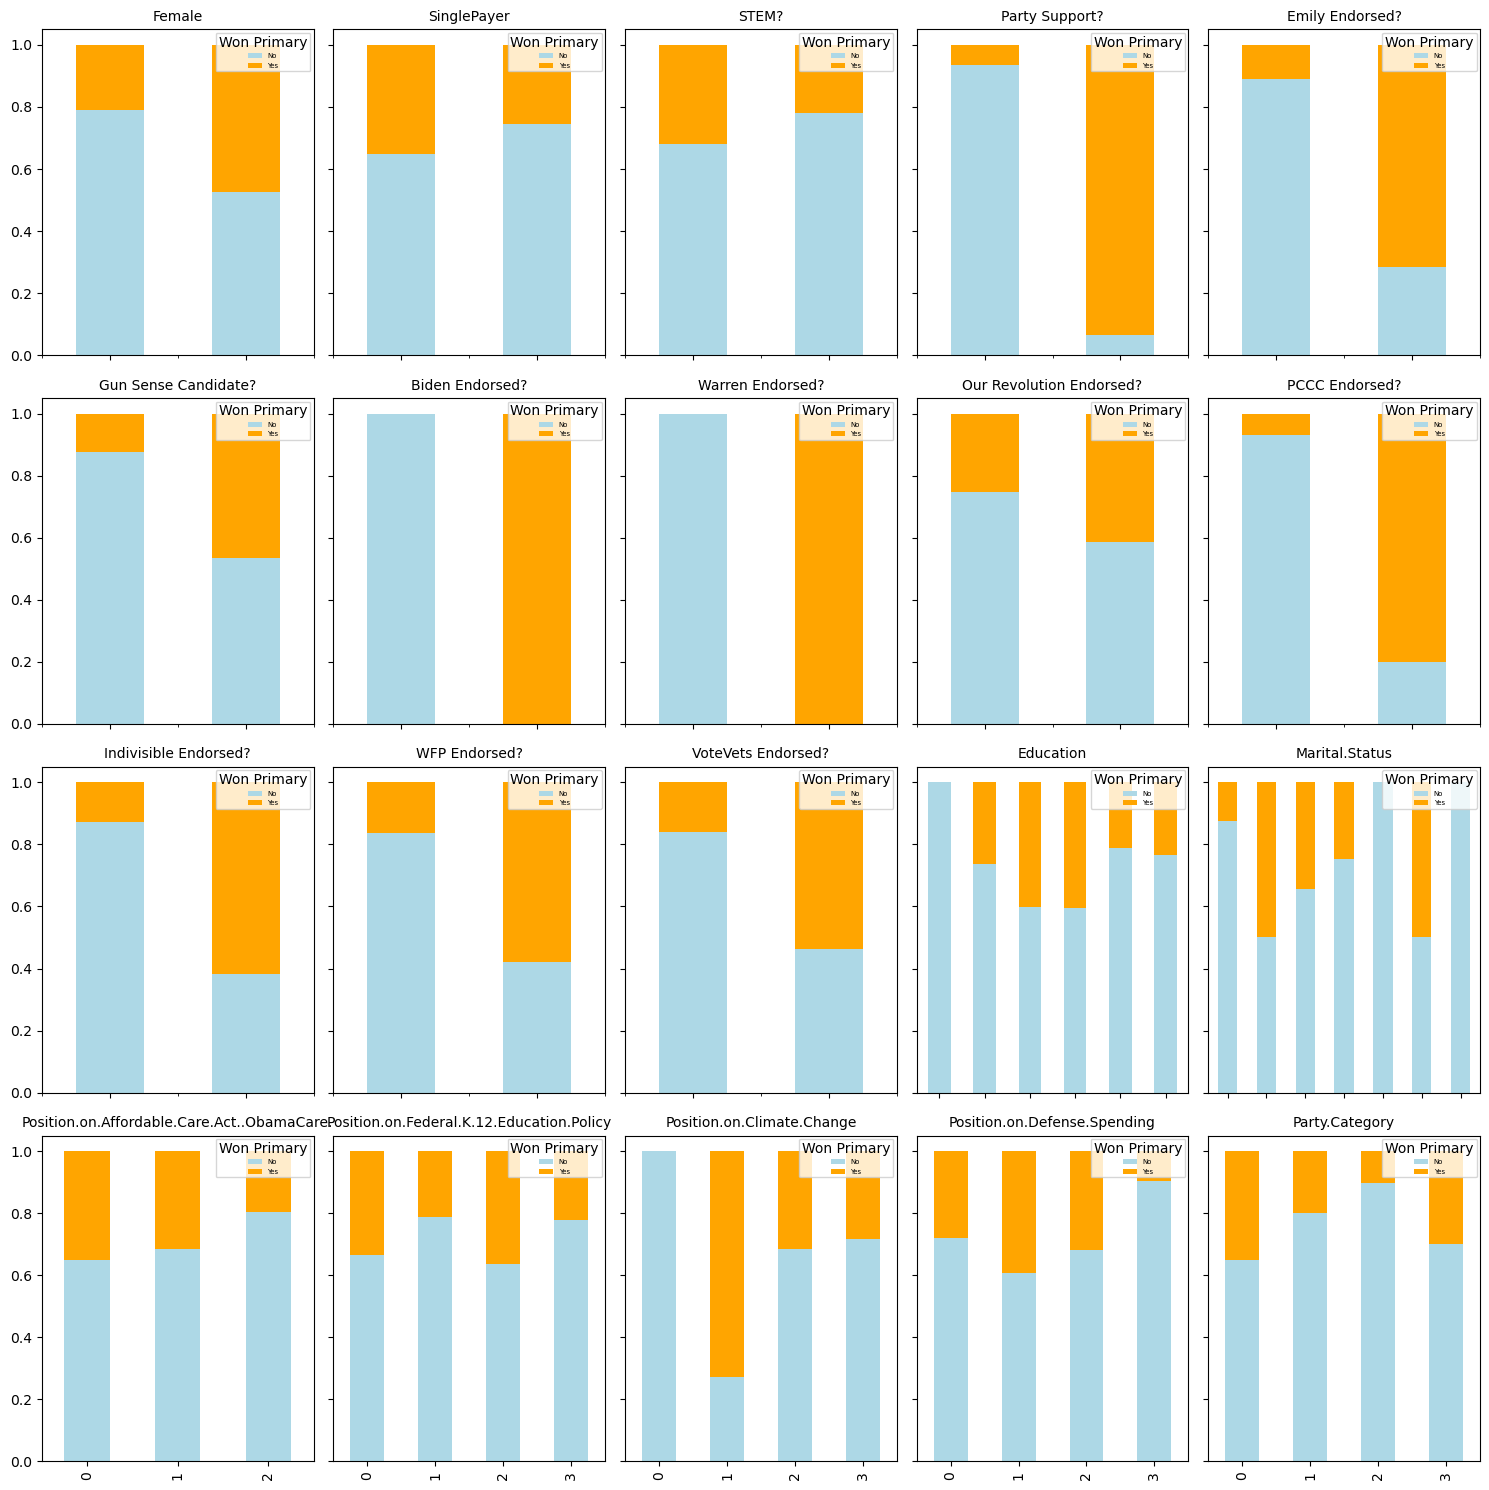

In [17]:
barplot(house, significant_cols)

Now that we know which variables are significant, we will OHE hust those. Just OHE the significant columns. 

```categorical``` is all categorical columns

```drop``` is the categories that are NOT significant

```house_to_encode``` is the house dataset with ```drop``` columns removed

In [22]:
drop = [x for x in categorical if x not in significant_cols]
house_to_encode = drop_columns(house, drop)

Now we one hot encode all categorical columns in ```house_to_encode```

```significant_cols``` is the significant categorical cols based on chi sq test

```ohe_result``` is the result of this one-hot-encoded dataframe, with the original, unencoded ```significant_cols``` columns dropped

In [23]:
ohe_result = pd.get_dummies(house_to_encode, columns=significant_cols)
ohe_result = drop_columns(ohe_result, significant_cols)

Now i want to manually drop the unexplainable columns to take of multicollinearity. I want this rather than dropping the frist column because our goal is explainiability.


```dependence_drop``` is the df with one OHE column dropped from each of the OHE features. 

In [24]:
contains_no_info =  [x for x in list(ohe_result.columns) if '_0' in x] + [x for x in list(ohe_result.columns) if '_No information' in x] + [x for x in list(ohe_result.columns) if '_Candidate provides complicated/complex/unclear position' in x] + [x for x in list(ohe_result.columns) if '_Candidate provides no information' in x] + [x for x in list(ohe_result.columns) if 'Other' in x]
dependence_drop = drop_columns(ohe_result, contains_no_info)

Now we want to drop any columns with low variance. 
```drop_low_variance``` is the dataframe now with low variance columns dropped

In [25]:
drop_low_variance = zero_dropper(dependence_drop)

shuffle before doing the VIF. 

```re_shuffled``` is the df with columns reshuffled so when doing VIF it does it not in order

In [26]:
re_shuffled = drop_low_variance.sample(frac=1, axis=1)

do VIF to drop highly correlated columns\

```X``` is all the X from ```re_shuffled```

```best_X``` is the result of dropping all highly multicollinear columns

```regression_ready``` is the dataframe with only the chosen ```best_X``` predicotrs

In [27]:
X = drop_columns(re_shuffled, ['General Status'])
best_X = drop_VIF_col(X, 2)
#all_cols = ['General Status'] + list(best_X.columns)
regression_ready = re_shuffled[['General Status'] + list(best_X.columns)]

Dropped: Total Endorsements with VIF of 27.298273495496204
Dropped: Party.Category_Progressive Democrat with VIF of 7.224297533451842
Dropped: total_runners with VIF of 4.073562715820594
Dropped: Position.on.Climate.Change_Candidate supports regulations and measures to combat climate change with VIF of 3.5691605993644173
Dropped: SinglePayer_1 with VIF of 2.576014670753325
Dropped: Marital.Status_Married with VIF of 2.4683385045971673


In [28]:
X = drop_columns(regression_ready, ['General Status'])

In [29]:
def drop_highly_correlated_columns(df, threshold=0.5):
    # Compute the correlation matrix
    corr_matrix = df.corr().abs()

    # Identify pairs of highly correlated features
    to_drop = set()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if corr_matrix.iloc[i, j] >= threshold:
                # Add one of the pair to the drop set
                to_drop.add(corr_matrix.columns[i])

    # Drop the selected columns
    df_reduced = df.drop(to_drop, axis=1)
    return df_reduced


In [34]:
reduced_no_corr = drop_highly_correlated_columns(X)
regression_ready

,General Status,Gun Sense Candidate?_1.0,Our Revolution Endorsed?_1.0,Party.Category_Establishment Democrat,STEM?_1,Position.on.Affordable.Care.Act..ObamaCare._Candidate explicitly supports ACA,Education_Associate's or less,Education_Master's Degree (includes MBA),Biden Endorsed?_1.0,Warren Endorsed?_1.0,...,Female_1,Marital.Status_Single,Position.on.Defense.Spending_Candidate opposes reductions in military spending,Marital.Status_Widowed,Position.on.Defense.Spending_Candidate supports a reduction in military spending,Education_J.D.,Position.on.Federal.K.12.Education.Policy_Candidate supports federal proposals for major education reform (including common core),WFP Endorsed?_1.0,Party Support?_1.0,Education_Bachelor's or some college
0,0,0,0,1,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1,1,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
3,1,0,0,0,0,0,0,1,0,0,...,1,0,1,0,0,0,1,0,0,0
4,0,1,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
627,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
628,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
629,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
630,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,1,1,0,1


In [38]:
categorical = get_ohe_cols(reduced_no_corr)
significant_cols = chi_square_test(regression_ready, categorical, 'General Status')

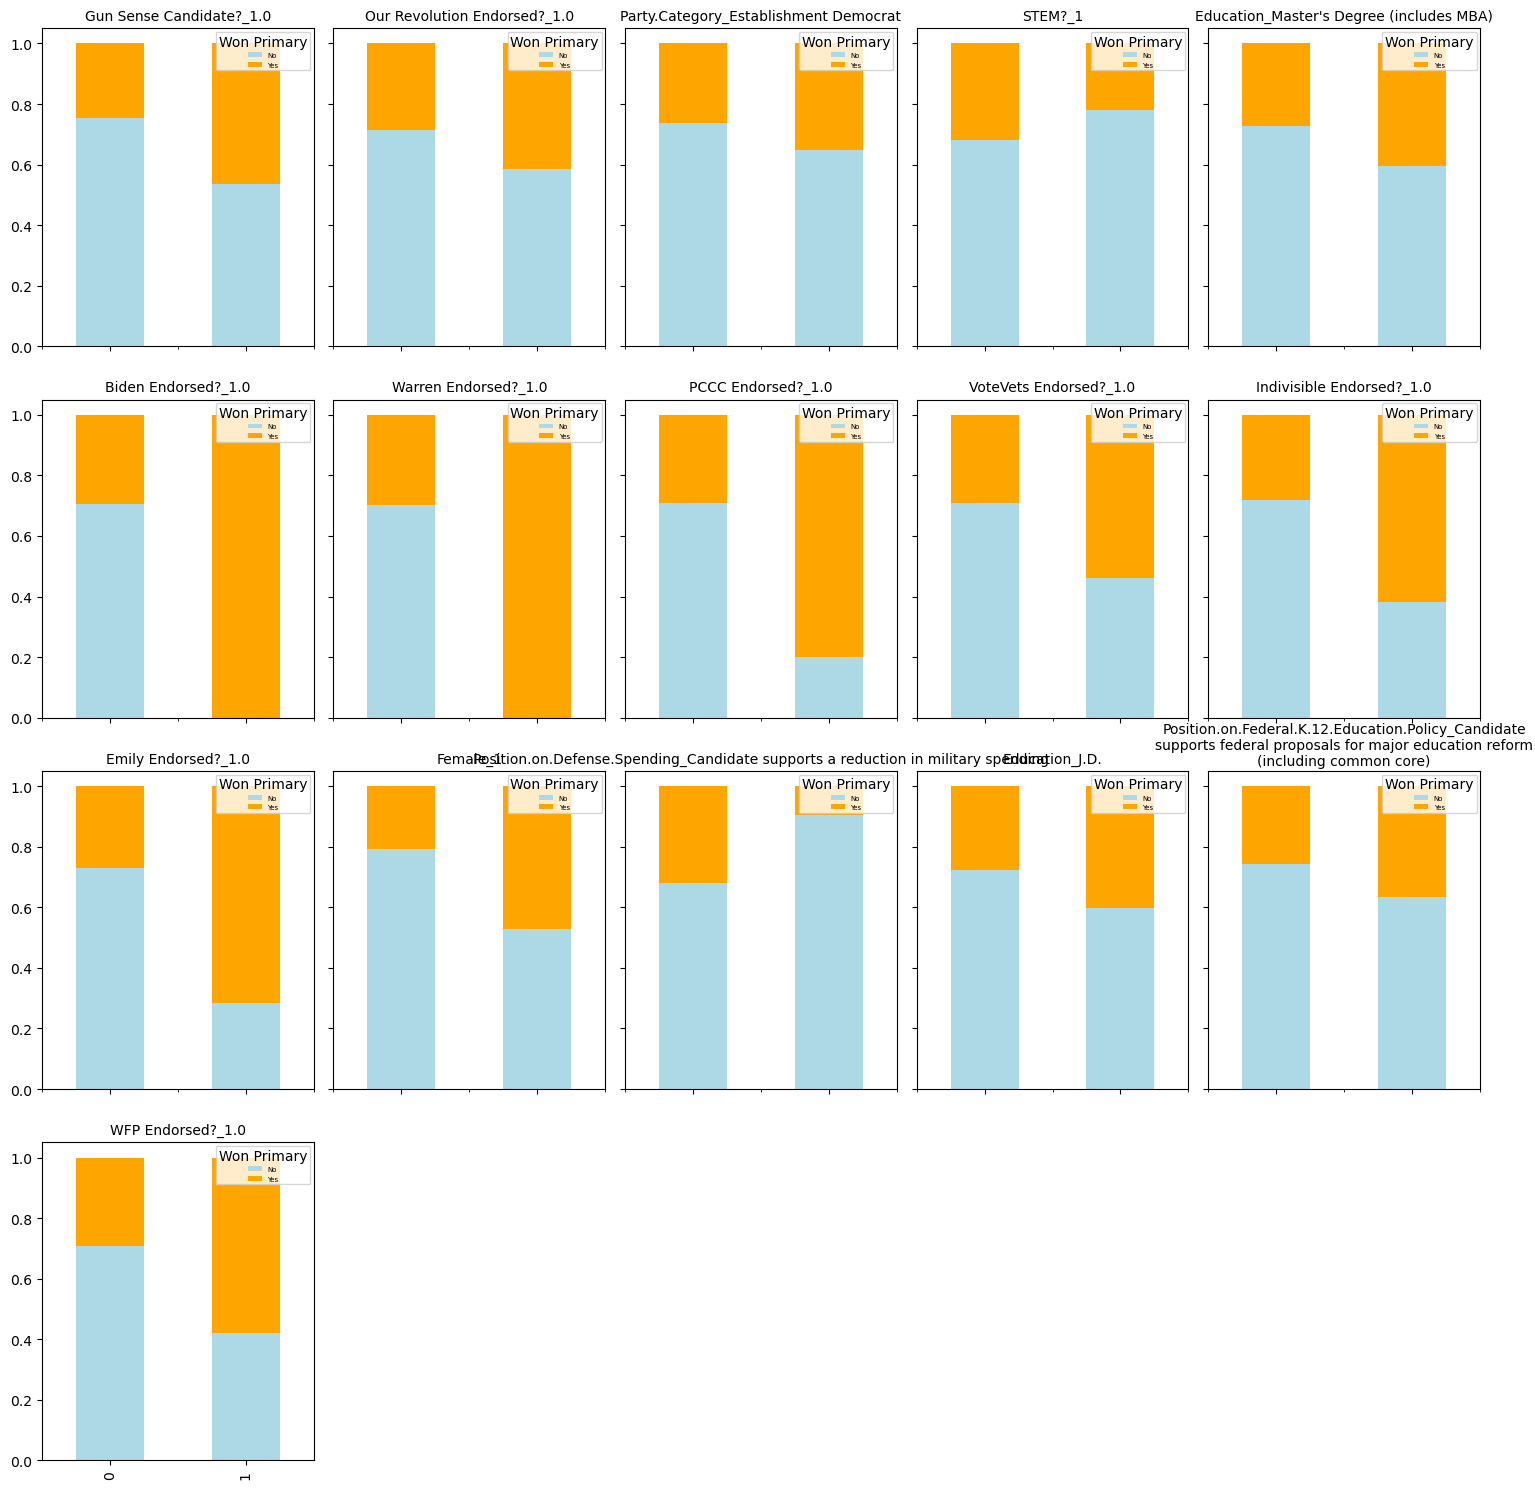

In [36]:
barplot(regression_ready, significant_cols)

In [41]:
drop = [x for x in categorical if x not in significant_cols]
house_for_aic = drop_columns(drops, drop)

NameError: name 'drops' is not defined

In [ ]:
aic(house_for_aic.astype(float),regression_ready['General Status'])

## We've dropped all the columns with high VIFs, so now we have a model to start with. We use a forward selectio nmodel staqrting with the un-dropped predictor columns. The resulting summary will tell us the 95% confidence interval of the coefficient for all the coefficients of the "best" predictors chosen by the forward selection function. We will look at these results, particularly whether the interval contains 0 or not, to remove more features and fit the model again. 

In [279]:
aic(df[X_lst].astype(float),df['General Status'])

NameError: name 'df' is not defined

## now we can inspect these best fit columns and remove those that were insignificant. ```exclude_cols``` contains a list of all such columns

In [129]:
#Precision: Measures the proportion of true positives among all predicted positives. Good for minimizing false positives.
#Recall (Sensitivity): Measures the proportion of actual positives correctly identified. Important when missing true positives is costly.

In [159]:
exclude_cols = ['Listed.military.service.','Elected Official?'
                ,'Gun Sense Candidate?_0.0','Our Revolution Endorsed?_0.0'
                ,'Education_No Education Information Listed','Education_Master\'s Degree (includes MBA)']

included_cols = [col for col in X_lst if col not in exclude_cols]

In [139]:
#trying again this time. 
aic(df[included_cols].astype(float),df['General Status'])

Optimization terminated successfully.
         Current function value: 0.602383
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.427569
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.397224
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.392317
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.389321
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.388222
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.373979
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.366293
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.359008
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.343021
  

(<class 'statsmodels.iolib.summary.Summary'>
 """
                            Logit Regression Results                           
 Dep. Variable:         General Status   No. Observations:                  632
 Model:                          Logit   Df Residuals:                      616
 Method:                           MLE   Df Model:                           15
 Date:                Sun, 10 Dec 2023   Pseudo R-squ.:                  0.4938
 Time:                        07:37:36   Log-Likelihood:                -195.60
 converged:                       True   LL-Null:                       -386.40
 Covariance Type:            nonrobust   LLR p-value:                 5.045e-72
                                                                                                                       coef    std err          z      P>|z|      [0.025      0.975]
 --------------------------------------------------------------------------------------------------------------------------------

# The AIC from that model was 423.2076283897824. We will exclde insignificant columns in the interest of imrpvoing our model .

In [163]:
exclude_cols = ['Listed.military.service.','Elected Official?'
                ,'Gun Sense Candidate?_0.0','Our Revolution Endorsed?_0.0'
                ,'Education_No Education Information Listed','Education_Master\'s Degree (includes MBA)', 'STEM?','receipts']

included_cols = [col for col in X_lst if col not in exclude_cols]

In [164]:
aic(df[included_cols].astype(float),df['General Status'])

Optimization terminated successfully.
         Current function value: 0.602383
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561420
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561006
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558923
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.536978
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.520457
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.517502
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.515056
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.506750
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.502910
  

(<class 'statsmodels.iolib.summary.Summary'>
 """
                            Logit Regression Results                           
 Dep. Variable:         General Status   No. Observations:                  632
 Model:                          Logit   Df Residuals:                      617
 Method:                           MLE   Df Model:                           14
 Date:                Sun, 10 Dec 2023   Pseudo R-squ.:                  0.2237
 Time:                        08:06:21   Log-Likelihood:                -299.96
 converged:                       True   LL-Null:                       -386.40
 Covariance Type:            nonrobust   LLR p-value:                 1.780e-29
                                                                                                                       coef    std err          z      P>|z|      [0.025      0.975]
 --------------------------------------------------------------------------------------------------------------------------------

# Yikes, tyrns out that excluding those columns made the AIC actually worse.
# . I'll do the same process one more time if not just for the vibes, and also to see if shit gets better

In [167]:
exclude_cols = ['Listed.military.service.','Elected Official?'
                ,'Gun Sense Candidate?_0.0','Our Revolution Endorsed?_0.0'
                ,'Education_No Education Information Listed','Education_Master\'s Degree (includes MBA)'
                , 'STEM?','receipts','Marital.Status_No information','Position.on.Affordable.Care.Act..ObamaCare._Candidate provides no information'
                , 'Previous.Electoral.Experience', 'Justice Dems Endorsed?_0.0'
               ]

included_cols = [col for col in X_lst if col not in exclude_cols]

In [168]:
aic(df[included_cols].astype(float),df['General Status'])

Optimization terminated successfully.
         Current function value: 0.602383
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561420
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.561006
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.538614
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.522378
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.519734
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.509500
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.505738
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.504792
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.494647
  

(<class 'statsmodels.iolib.summary.Summary'>
 """
                            Logit Regression Results                           
 Dep. Variable:         General Status   No. Observations:                  632
 Model:                          Logit   Df Residuals:                      621
 Method:                           MLE   Df Model:                           10
 Date:                Sun, 10 Dec 2023   Pseudo R-squ.:                  0.2154
 Time:                        08:07:46   Log-Likelihood:                -303.18
 converged:                       True   LL-Null:                       -386.40
 Covariance Type:            nonrobust   LLR p-value:                 1.512e-30
                                                                                                                       coef    std err          z      P>|z|      [0.025      0.975]
 --------------------------------------------------------------------------------------------------------------------------------

## Damn that's crazy it wen tdown like by 1. So we will use the first model becaues that. had thelowest AIC. 

In [176]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, balanced_accuracy_score, matthews_corrcoef

def do_regression(df, y_col, predictor_list): 
    
    train, test = train_test_split(df, test_size = .30, random_state = 101)
    X_train = train[predictor_list]
    y_train = train[y_col]
    X_test = test[predictor_list]
    y_test = test[y_col]
    logisticmodel = LogisticRegression(penalty='none', solver='lbfgs')
    logisticmodel.fit(X_test, y_test)
    probs = logisticmodel.predict_proba(X_test)[:, 1]
    y_hat = (probs > 0.5).astype(np.int64)
    accuracy = np.mean(y_test == y_hat)
    
    precision = precision_score(y_test, y_hat)
    recall = recall_score(y_test, y_hat)
    # Display the results
    print(f'Precision: {precision}')
    prevalence = np.mean(df[y_col] == 1)
    print(f"Prevalence: {prevalence}")
    print(f'Recall: {recall:.4f}')
    f1 = f1_score(y_test, y_hat)
    roc_auc = roc_auc_score(y_test, y_hat)
    average_precision = average_precision_score(y_test, y_hat)
    balanced_accuracy = balanced_accuracy_score(y_test, y_hat)
    print(f"Accuracy on test set: {accuracy}")

In [177]:
best_model_cols = ['Partisan Lean', 'receipts', 'Female', 'Race', 'STEM?', 'Party Support?_0.0', 'Gun Sense Candidate?_1.0', 'Our Revolution Endorsed?_1.0'
                   , 'Justice Dems Endorsed?_0.0', 'Indivisible Endorsed?_0.0'
                   , 'VoteVets Endorsed?_0.0', 'Education_J.D.', 'Position.on.National.Debt.Deficit_Candidate calls for lowering the national debt or calls for deficit reduction'
                   , 'Position.on.Criminal.Justice.Reform_Candidate supports major criminal justice reform', 'Party.Category_Establishment Democrat']


#include_cols_regresion = ['receipts', 'Female', 'STEM?', 'Party Support?_0.0', 'Emily Endorsed?_0.0', 'Gun Sense Candidate?_1.0', 'Our Revolution Endorsed?_1.0', 'Justice Dems Endorsed?_0.0', 'Indivisible Endorsed?_0.0', 'VoteVets Endorsed?_0.0', 'Position.on.Business.Regulations_Candidate supports placing smart regulations on business', 'Position.on.National.Debt.Deficit_Candidate calls for lowering the national debt or calls for deficit reduction', 'Party.Category_Establishment Democrat']
do_regression(df, 'General Status', best_model_cols)

Precision: 0.27976190476190477
Prevalence: 0.30063291139240506
Recall: 0.9592
Accuracy on test set: 0.3526315789473684


In [178]:
def do_regression_cv(df, y_col, predictor_list):
    X = df[predictor_list]
    y = df[y_col]

    logisticmodel = LogisticRegression(penalty='none', solver='lbfgs')

    # Using cross-validation
    scoring = ['precision', 'recall', 'f1', 'roc_auc', 'average_precision', 'balanced_accuracy']
    cv_results = cross_validate(logisticmodel, X, y, cv=5, scoring=scoring)

    # Display the results
    for score in scoring:
        print(f"{score.capitalize()}: {np.mean(cv_results['test_' + score]):.4f}")

    prevalence = np.mean(y == 1)
    print(f"Prevalence: {prevalence}")


## Deprecated

In [ ]:




# ohe_result = pd.get_dummies(ohe_this, columns=ohe_cols)

# ohe_result = drop_columns(ohe_result, ohe_cols)
# #ohe_result

ohe_result.columns

to_binarize = ohe_result.copy()
binarized = binarize_cols(to_binarize)
#binarized

binarized
to_resample = binarized.copy()
to_resample.columns

to_resample['No Labels Support?_No'].sum()

to_resample['No Labels Support?_Yes'].sum()

X_to_oversample = to_resample.drop(['General Status'],axis=1)
y_to_oversample = to_resample['General Status']

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(sampling_strategy=0.4,random_state=101)

ros.fit(X_to_oversample, y_to_oversample)

X_resampled, y_resampled = ros.fit_resample(X_to_oversample, y_to_oversample)


In [ ]:
combined_df = pd.concat([X_resampled, y_resampled.reset_index(drop=True)], axis=1)
# Shuffle the combined DataFrame
shuffled_df = combined_df.sample(frac=1, random_state=101).reset_index(drop=True)

# Split the DataFrame back into X and y
X_resampled_shuffled = shuffled_df.iloc[:, :-1]
y_resampled_shuffled = shuffled_df.iloc[:, -1]


In [ ]:
shuffled_df.columns
shuffled_df = move_column_to_front(shuffled_df,['General Status'])

shuffled_df.columns
shuffled_df = drop_columns(shuffled_df, ['total_runners_brookings_2', 'Race_Nonwhite', 'Guns Sense Candidate?_No', 'Position.on.Legalization.Decriminalization.of.Marijuana.Policy_Candidate provides no information' ])
shuffled_df.shape





to_drop_sparse = shuffled_df.copy()
dropped_sparse = zero_dropper(to_drop_sparse)
dropped_sparse.columns





X = dropped_sparse.drop('General Status', axis=1)
best_X = drop_VIF_col(X)
best_X_lst = list(best_X.columns)

best_X_lst

y_best_X_lst = best_X_lst + ['General Status']

X = best_X.copy()
vif_info = pd.DataFrame()
vif_info['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_info['Column'] = X.columns
vif_info = vif_info.sort_values('VIF', ascending=False)

def aic(X, y):
    best_features = []
    best_aic = float('inf')

    for feature in X.columns:
        # Create a temporary DataFrame with the current set of best features plus the new feature
        X_temp = sm.add_constant(X[best_features + [feature]])

       
        model = sm.Logit(y, X_temp)  # Fit the logistic regression model
        result = model.fit()  # disp=0 suppresses the fit output

        # Check AIC and update if it is lower
        if result.aic < best_aic:
            best_aic = result.aic
            best_features.append(feature)

    # Fit the final model with the best features
    X_final = sm.add_constant(X[best_features])
    final_model = sm.Logit(y, X_final)
    final_result = final_model.fit(disp=0)

    # You might want to return the final model, its summary, or AIC
    print(f"{best_features}")
    return final_result.summary(), final_result.aic


shuffled_df = shuffled_df.sample(frac=1).reset_index(drop=True)
fwd_selection_X = shuffled_df.drop('General Status',axis=1).dropna()
fwd_selection_X = fwd_selection_X.astype(float)
fwd_selection_y = shuffled_df['General Status']

aic(fwd_selection_X, fwd_selection_y)

X = output.drop('General Status',axis=1).dropna()
X = X.astype(float)
y = output['General Status']

#aic(X, y)
output

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, balanced_accuracy_score, matthews_corrcoef

def do_regression(df, y_col, predictor_list): 
    train, test = train_test_split(df, test_size = .30, random_state = 101)
    X_train = train[predictor_list]
    y_train = train[y_col]
    X_test = test[predictor_list]
    y_test = test[y_col]
    logisticmodel = LogisticRegression(penalty='none', solver='lbfgs')
    logisticmodel.fit(X_test, y_test)
    probs = logisticmodel.predict_proba(X_test)[:, 1]
    y_hat = (probs > 0.5).astype(np.int64)
    accuracy = np.mean(y_test == y_hat)
    
    precision = precision_score(y_test, y_hat)
    recall = recall_score(y_test, y_hat)
    # Display the results
    print(f'Precision: {precision:.4f}')
    prevalence = np.mean(df[y_col] == 1)
    print(f"Prevalence: {prevalence}")
    print(f'Recall: {recall:.4f}')
    f1 = f1_score(y_test, y_hat)
    roc_auc = roc_auc_score(y_test, y_hat)
    average_precision = average_precision_score(y_test, y_hat)
    balanced_accuracy = balanced_accuracy_score(y_test, y_hat)
    print(f"Accuracy on test set: {accuracy}")


do_regression(output,'General Status',new_predictors)

from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, balanced_accuracy_score, matthews_corrcoef


def do_regression_cv(df, y_col, predictor_list):
    X = df[predictor_list]
    y = df[y_col]

    logisticmodel = LogisticRegression(penalty='none', solver='lbfgs')

    # Using cross-validation
    scoring = ['precision', 'recall', 'f1', 'roc_auc', 'average_precision', 'balanced_accuracy']
    cv_results = cross_validate(logisticmodel, X, y, cv=5, scoring=scoring)

    # Display the results
    for score in scoring:
        print(f"{score.capitalize()}: {np.mean(cv_results['test_' + score]):.4f}")

    prevalence = np.mean(y == 1)
    print(f"Prevalence: {prevalence}")

# Example usage
# do_regression(df, 'your_target_column', ['list', 'of', 'predictor', 'columns'])


do_regression_cv(output,'General Status',new_predictors)

from sklearn.metrics import confusion_matrix

# from sklearn.feature_selection import SequentialFeatureSelector
# feature_selector = SequentialFeatureSelector(
#         LogisticRegression(),
#         n_features_to_select="auto",
#         direction="forward"
#     )


# from sklearn.feature_selection import SequentialFeatureSelector
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.datasets import load_iris
# X, y = load_iris(return_X_y=True)
# knn = KNeighborsClassifier(n_neighbors=3)
# sfs = SequentialFeatureSelector(knn, n_features_to_select=3)
# sfs.fit(X, y)
# sfs.get_support()
# sfs.transform(X).shape

# def ohe_and_avoid_multicollinearity(df, columns_to_ohe):
#     # nan_columns_dropped = []
#     # first_cols_dropped = []
#     my_last_fucking_straw = []
#     res = df.copy()
#     for col in columns_to_ohe:
#         ohe_df = pd.get_dummies(res[col], prefix=col,dummy_na=True)
#         res = res.drop(col, axis=1)
#         res = pd.concat([res, ohe_df], axis=1)
#         my_last_fucking_straw.append(col)
#             # nan_col = col + '_nan'
#             # if (nan_col in ohe_df.columns):
#             #     valid = (ohe_df[nan_col]==1).sum()>50
#             #     if valid:
#             #         ohe_df = ohe_df.drop(nan_col, axis=1)
#             #         nan_columns_dropped.append([col, nan_col])
#             # else:
#             #     first_cols_dropped.append([col, ohe_df.iloc[:, 0]])
#             #     ohe_df = ohe_df.iloc[:, 1:]
#             # # Merge the OHE columns back into the original dataframe

#             #print("\n".join(my_list))
#     # for i in nan_columns_dropped:
#     #     print(f"col:  {i[0]}\ndrop: {i[1]}\n")
#     # for i in first_cols_dropped:
#     #     print(f"col:  {i[0]}\ndrop: {i[1].name}\n")
#     # print(f"number of cols expected to OHE: {len(columns_to_ohe)}\nnumber of cols dropped: {len(nan_columns_dropped) + len(first_cols_dropped)}")    
#     print(f"{my_last_fucking_straw}")
#     return res

#new_df = ohe_and_avoid_multicollinearity(new_df, ohe_cols)

# def drop_columns(df, col_lst):
#     for i in col_lst:
#         if i in df.columns:
#             df.drop(i, axis=1)
#     return df

# new_df = drop_columns(new_df.copy(),['Primary.Outcome', 'District Abbrev','House Candidate','Brookings Candidate','total_runners_house','District','Previous.Electoral.Experience','SinglePayer'])
# new_df = move_column_to_front(new_df, ['General Status'])


new_df.to_csv(Path('ready_for_modelling.csv'))

# correlation_matrix = new_df.corr()
# cols = correlation_matrix.columns
# #correlation_matrix
# new_df = drop_columns(new_df,['Primary.Outcome', 'District Abbrev','House Candidate','Brookings Candidate','total_runners_house','District','Previous.Electoral.Experience','SinglePayer'])

# new_df

# y = new_df['General Status']# a series
# y

# X = drop_columns(new_df, ['General Status']) # a df
# #X = X.drop(['General Status'],axis=1)
# #drop_columns
# X.copy()

X.columns

# import statsmodels.api as sm

# def aic(X, y):
#     best_features = []
#     best_aic = float('inf')

#     for feature in X.columns:
#         # Create a temporary DataFrame with the current set of best features plus the new feature
#         X_temp = sm.add_constant(X[best_features + [feature]])

       
#         model = sm.Logit(y, X_temp)  # Fit the logistic regression model
#         result = model.fit()  # disp=0 suppresses the fit output

#         # Check AIC and update if it is lower
#         if result.aic < best_aic:
#             best_aic = result.aic
#             best_features.append(feature)

#     # Fit the final model with the best features
#     X_final = sm.add_constant(X[best_features])
#     final_model = sm.Logit(y, X_final)
#     final_result = final_model.fit(disp=0)

#     # You might want to return the final model, its summary, or AIC
#     return final_result.summary(), final_result.aic


# aic(X.copy(),y.copy())

The smallest possible value for VIF is 1, which indicates the complete absence of collinearity. Typically in practice there is a small amount of collinearity among the predictors. As a rule of thumb, a VIF value that exceeds 5 or 10 indicates a problematic amount of collinearity.In the Credit data, a regression of balance on age, rating, and limit indicates that the predictors have VIF values of 1.01, 160.67, and 160.59. As we suspected, there is considerable collinearity in the data!When faced with the problem of collinearity, there are two simple solu- tions. The first is to drop one of the problematic variables from the regres- sion. This can usually be done without much compromise to the regression fit, since the presence of collinearity implies that the information that this variable provides about the response is redundant in the presence of the other variables. For instance, if we regress balance onto age and limit, without the rating predictor, then the resulting VIF values are close to the minimum possible value of 1, and the R2 drops from 0.754 to 0.75. So dropping rating from the set of predictors has effectively solved the collinearity problem without compromising the fit.

In [ ]:
# correlation_df = pd.DataFrame(correlation_matrix.iloc[0]).abs().sort_values("General Status",ascending=False)
# correlation_df.head(3)

In [549]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor 

In [548]:
#get_X_df(new_df, 'General Status').columns

In [ ]:
# def aic(X, y):
#     best_features = []
#     best_aic = float('inf') 

#     for feature in X.columns:
#         # Add a constant term and the current feature
#         X = sm.add_constant(X[best_features + [feature]])

#         # Fit the logistic regression model
#         model = sm.Logit(y, X)
#         result = model.fit()

#         # Check AIC and update if it is lower
#         if result.aic < best_aic:
#             best_aic = result.aic
#             best_features.append(feature)

#     # Fit the final model with the best features
#     X_final = sm.add_constant(X[best_features])
#     final_model = sm.Logit(y, X_final)
#     final_result = final_model.fit()

#     print(final_result.summary(), final_result.aic)

In [353]:
# from sklearn.preprocessing import OneHotEncoder
# encoder = OneHotEncoder(drop='first')
# encoder.fit(new_df[to_ohe])
# encoded_data = encoder.transform(new_df[to_ohe]).toarray()
# encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out())
# final_df = pd.concat([new_df, encoded_df], axis=1)
# final_df.drop(to_ohe, axis=1, inplace=True)

In [264]:
# #new_df.columns

# new_df[['General Status', 'Partisan Lean','Candidate.Gender',
#        'Listed.military.service.', 'Education', 'Marital.Status',
#        'Previous.Electoral.Experience',
#        'Position.on.Affordable.Care.Act..ObamaCare.',
#        'Position.on.Minimum.Wage', 'Position.on.Federal.Taxes',
#        'Position.on.Business.Regulations', 'Position.on.National.Debt.Deficit',
#        'Position.on.Social.Security', 'Position.on.Gun.Control',
#        'Position.on.Immigration', 'Position.on.Abortion',
#        'Position.on.Same.Sex.Marriage', 'Position.on.Criminal.Justice.Reform',
#        'Position.on.Federal.K.12.Education.Policy',
#        'Position.on.Climate.Change', 'Position.on.Campaign.Finance.Reform',
#        'Position.on.Legalization.Decriminalization.of.Marijuana.Policy',
#        'Position.on.Defense.Spending', 'Position.on.Handling.Terrorism.Abroad',
#        'Position.on.Russia', 'Party.Category', 'Trump.Mention',
#        'Obama.Mention', 'Sanders.Mention', 'Clinton.Mention',
#        'Special.Counsel.Mention', 'Travel.Ban.Mention', 'SinglePayer',
#         'Race', 'Veteran?', 'LGBTQ?', 'Elected Official?', 'Self-Funder?', 'STEM?', 'Obama Alum?',
#        'Party Support?', 'Emily Endorsed?', 'Guns Sense Candidate?',
#        'Biden Endorsed?', 'Warren Endorsed? ', 'Sanders Endorsed?',
#        'Our Revolution Endorsed?', 'Justice Dems Endorsed?', 'PCCC Endorsed?',
#        'Indivisible Endorsed?', 'WFP Endorsed?', 'VoteVets Endorsed?',
#        'No Labels Support?']]

'total_runners'

In [146]:
# encoder = OneHotEncoder(drop='first')
# encoder.fit(new_df[to_ohe])
# encoded_data = encoder.transform(new_df[to_ohe]).toarray()
# encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out())


# final_df = pd.concat([new_df, encoded_df], axis=1)
# final_df.drop(to_ohe, axis=1, inplace=True)

Index(['General Status_1.0', 'Partisan Lean_-62.060001',
       'Partisan Lean_-61.459999', 'Partisan Lean_-60.810001',
       'Partisan Lean_-55.029999', 'Partisan Lean_-54.009998',
       'Partisan Lean_-49.509998', 'Partisan Lean_-49.110001',
       'Partisan Lean_-49.009998', 'Partisan Lean_-48.73',
       ...
       'PCCC Endorsed?_Yes', 'PCCC Endorsed?_nan', 'Indivisible Endorsed?_Yes',
       'Indivisible Endorsed?_nan', 'WFP Endorsed?_Yes', 'WFP Endorsed?_nan',
       'VoteVets Endorsed?_Yes', 'VoteVets Endorsed?_nan',
       'No Labels Support?_Yes', 'No Labels Support?_nan'],
      dtype='object', length=315)

In [265]:
#correlation_df = pd.DataFrame(correlation_matrix.iloc[0]).abs().sort_values("General Status",ascending=False)
#correlation_df.head(30)/


## Step 2: Drop one column from each OHE variable

## Step 3: Use forward selection to model select